In [6]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [7]:
import os
import tensorflow as tf
import numpy as np
import seaborn as sns
import pathlib
from IPython import display
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report


In [8]:
# Downloading the mini_speech_commands dataset from the external URL
data = tf.keras.utils.get_file(
'mini_speech_commands.zip',
origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
extract=True,
cache_dir='.', cache_subdir='data')


182082353/182082353 [==============================] - 34s 0us/step


In [9]:
os.listdir('./data/')


['mini_speech_commands', 'mini_speech_commands.zip', '__MACOSX']

In [10]:
# Using audio_dataset_from_directory function to create dataset with audio data
training_set, validation_set = tf.keras.utils.audio_dataset_from_directory(
	directory='./data/mini_speech_commands',
	batch_size=16,
	validation_split=0.2,
	output_sequence_length=16000,
	seed=0,
	subset='both')

# Extracting audio labels
label_names = np.array(training_set.class_names)
print("label names:", label_names)


Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.
label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [12]:
# Defining the squeeze function
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

# Applying the function on the dataset obtained from previous step
training_set = training_set.map(squeeze, tf.data.AUTOTUNE)
validation_set = validation_set.map(squeeze, tf.data.AUTOTUNE)


In [13]:
# Visualize the waveform
audio, label = next(iter(training_set))
display.display(display.Audio(audio[0], rate=16000))


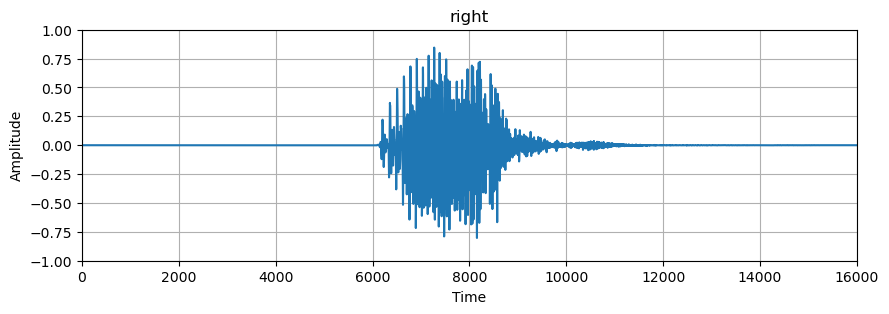

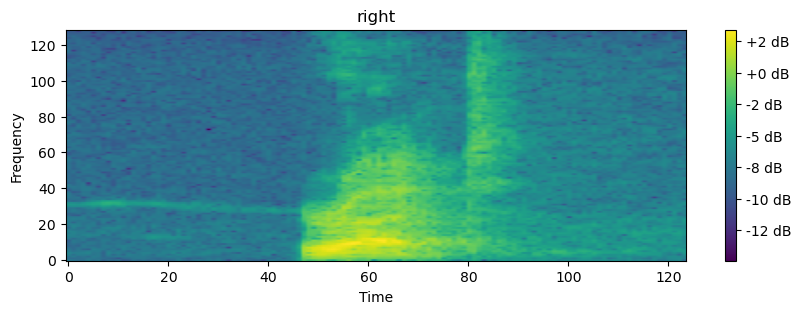

In [14]:
# Plot the waveform
def plot_wave(waveform, label):
	plt.figure(figsize=(10, 3))
	plt.title(label)
	plt.plot(waveform)
	plt.xlim([0, 16000])
	plt.ylim([-1, 1])
	plt.xlabel('Time')
	plt.ylabel('Amplitude')
	plt.grid(True)

# Convert waveform to spectrogram
def get_spectrogram(waveform):
	spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
	spectrogram = tf.abs(spectrogram)
	return spectrogram[..., tf.newaxis]

# Plot the spectrogram
def plot_spectrogram(spectrogram, label):
	spectrogram = np.squeeze(spectrogram, axis=-1)
	log_spec = np.log(spectrogram.T + np.finfo(float).eps)
	plt.figure(figsize=(10, 3))
	plt.title(label)
	plt.imshow(log_spec, aspect='auto', origin='lower')
	plt.colorbar(format='%+2.0f dB')
	plt.xlabel('Time')
	plt.ylabel('Frequency')

# Plotting the waveform and the spectrogram of a random sample
audio, label = next(iter(training_set))

# Plot the wave with its label name
plot_wave(audio[0], label_names[label[0]])

# Plot the spectrogram with its label name
plot_spectrogram(get_spectrogram(audio[0]), label_names[label[0]])


In [15]:
# Creating spectrogram dataset from waveform or audio data
def get_spectrogram_dataset(dataset):
	dataset = dataset.map(
		lambda x, y: (get_spectrogram(x), y),
		num_parallel_calls=tf.data.AUTOTUNE)
	return dataset

# Applying the function on the audio dataset
train_set = get_spectrogram_dataset(training_set)
validation_set = get_spectrogram_dataset(validation_set)

# Dividing validation set into two equal val and test set
val_set = validation_set.take(validation_set.cardinality() // 2)
test_set = validation_set.skip(validation_set.cardinality() // 2)


In [16]:
train_set_shape = train_set.element_spec[0].shape
val_set_shape = val_set.element_spec[0].shape
test_set_shape = test_set.element_spec[0].shape

print("Train set shape:", train_set_shape)
print("Validation set shape:", val_set_shape)
print("Testing set shape:", test_set_shape)


Train set shape: (None, 124, 129, 1)
Validation set shape: (None, 124, 129, 1)
Testing set shape: (None, 124, 129, 1)


In [17]:
# Defining the model
def get_model(input_shape, num_labels):
	model = tf.keras.Sequential([
		tf.keras.layers.Input(shape=input_shape),
		# Resizing the input to a square image of size 64 x 64 and normalizing it
		tf.keras.layers.Resizing(64, 64),
		tf.keras.layers.Normalization(),
		
		# Convolution layers followed by MaxPooling layer
		tf.keras.layers.Conv2D(64, 3, activation='relu'),
		tf.keras.layers.Conv2D(128, 3, activation='relu'),
		tf.keras.layers.MaxPooling2D(),
		tf.keras.layers.Dropout(0.5),
		tf.keras.layers.Flatten(),
		
		# Dense layer
		tf.keras.layers.Dense(256, activation='relu'),
		tf.keras.layers.Dropout(0.5),
		
		# Softmax layer to get the label prediction
		tf.keras.layers.Dense(num_labels, activation='softmax')
	])
	# Printing model summary
	model.summary()
	return model

# Getting input shape from the sample audio and number of classes
input_shape = next(iter(train_set))[0][0].shape
print("Input shape:", input_shape)
num_labels = len(label_names)

# Creating a model
model = get_model(input_shape, num_labels)


Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 64, 64, 1)         0         
                                                                 
 normalization (Normalizati  (None, 64, 64, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           

In [18]:
model.compile(
	optimizer=tf.keras.optimizers.Adam(),
	loss=tf.keras.losses.SparseCategoricalCrossentropy(),
	metrics=['accuracy'],
)

EPOCHS = 10
history = model.fit(
	train_set,
	validation_data=val_set,
	epochs=EPOCHS,
)


Epoch 1/10
400/400 [==============================] - 410s 1s/step - loss: 1.4257 - accuracy: 0.5153 - val_loss: 0.8126 - val_accuracy: 0.7450
Epoch 2/10
400/400 [==============================] - 391s 976ms/step - loss: 0.7658 - accuracy: 0.7588 - val_loss: 0.5386 - val_accuracy: 0.8375
Epoch 3/10
400/400 [==============================] - 380s 949ms/step - loss: 0.5169 - accuracy: 0.8344 - val_loss: 0.5442 - val_accuracy: 0.8300
Epoch 4/10
400/400 [==============================] - 387s 965ms/step - loss: 0.4015 - accuracy: 0.8703 - val_loss: 0.4027 - val_accuracy: 0.8737
Epoch 5/10
400/400 [==============================] - 391s 978ms/step - loss: 0.3332 - accuracy: 0.8905 - val_loss: 0.4200 - val_accuracy: 0.8662
Epoch 6/10
400/400 [==============================] - 388s 970ms/step - loss: 0.2746 - accuracy: 0.9045 - val_loss: 0.3959 - val_accuracy: 0.8712
Epoch 7/10
400/400 [==============================] - 1373s 3s/step - loss: 0.2205 - accuracy: 0.9255 - val_loss: 0.3864 - val_

Text(0, 0.5, 'Accuracy')

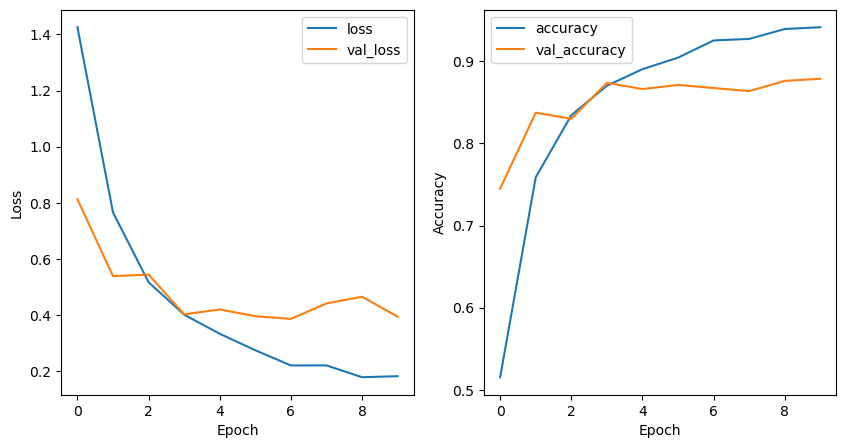

In [19]:
# Plotting the history
metrics = history.history
plt.figure(figsize=(10, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


50/50 [==============================] - 6s 88ms/step


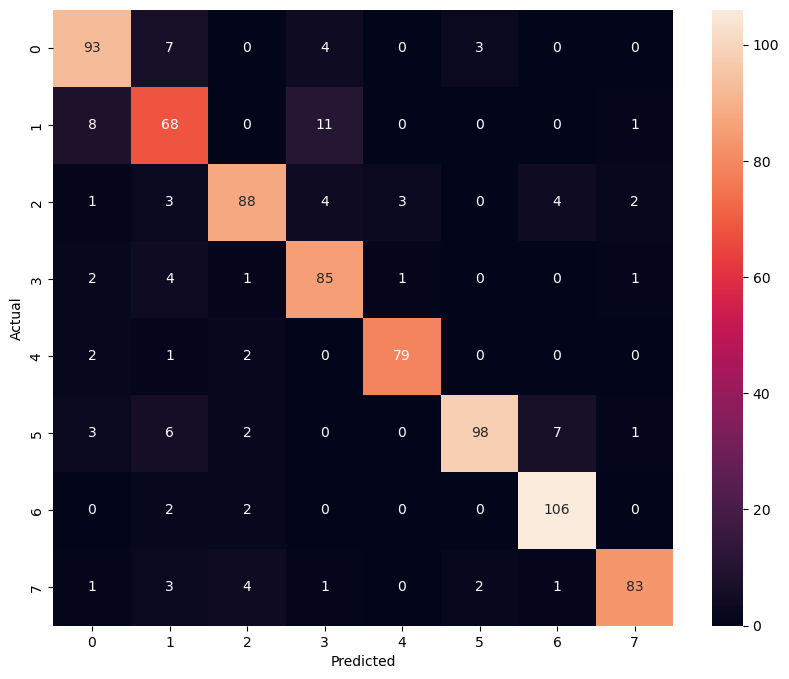

In [20]:
# Confusion matrix
y_pred = np.argmax(model.predict(test_set), axis=1)
y_true = np.concatenate([y for x, y in test_set], axis=0)
cm = tf.math.confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [21]:
report = classification_report(y_true, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.85      0.87      0.86       107
           1       0.72      0.77      0.75        88
           2       0.89      0.84      0.86       105
           3       0.81      0.90      0.85        94
           4       0.95      0.94      0.95        84
           5       0.95      0.84      0.89       117
           6       0.90      0.96      0.93       110
           7       0.94      0.87      0.91        95

    accuracy                           0.88       800
   macro avg       0.88      0.87      0.87       800
weighted avg       0.88      0.88      0.88       800



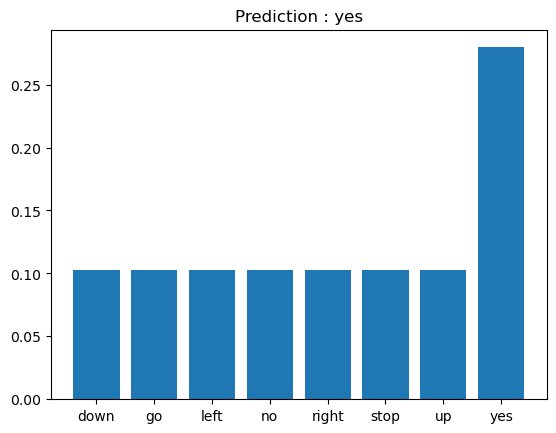

In [22]:
path = 'data/mini_speech_commands/yes/004ae714_nohash_0.wav'
Input = tf.io.read_file(str(path))
x, sample_rate = tf.audio.decode_wav(Input, desired_channels=1, desired_samples=16000,)
audio, labels = squeeze(x, 'yes')

waveform = audio
display.display(display.Audio(waveform, rate=16000))

x = get_spectrogram(audio)
x = tf.expand_dims(x, axis=0)

prediction = model(x)
plt.bar(label_names, tf.nn.softmax(prediction[0]))
plt.title('Prediction : '+label_names[np.argmax(prediction, axis=1).item()])
plt.show()
